In [2]:
#README
import os
f = open(os.getenv('HOME') + '/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

<function TextIOWrapper.close()>

### 데이터를 읽어보면 주목할만한 점이 있다.
- 유저에 대한 정보를 전혀 알 수가 없다.
- 아이템에 대한 정보도 전혀 알 수 없다.

## 1. Data preprocess

- 데이터를 불러와 살펴보고 통계치들을 살펴보겠다.
- Click 데이터에 있는 Sessoion Id, TimeStamp, ItemId 칼럼만 사용할 예정

In [3]:
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat')

In [5]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [6]:
data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [7]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

##### Session length

In [8]:
# session length : SessionId를 공유하는 데이터 row의 갯수. 해당 세션의 사용자가 그 세션동안 몇 개의 상품정보를 클릭했는지이다.
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

In [9]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [10]:
session_length.min(), session_length.max()

(1, 200)

- 최소 1번, 최대 200번까지 클릭한 사람이 있는데,

In [11]:
session_length.quantile(0.999)

41.0

- 99.9% 세션은 길이가 41 이하이다. 길이가 200인 세션에 대해 보자

In [13]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


- 유저들의 서비스 이용행태는 매우 다양하다. 그러므로 데이터 전처리를 어떻게 할 지는 모델을 만드는 사람이 잘 판단해야 한다. 예를 들어 음악 데이터의 경우 어떤 사람은 하루종일 랜덤 재생을 할 수도 있는데, 이 유저의 데이터를 그대로 사용하는게 좋을까? 판단은 우리의 몫이다.

##### Session Time

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
#한 달치 데이터만 사용 예정
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


##### Data Cleansing

- 우리의 목적은 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 session length가 1인 세션은 제거하자.

In [17]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
        return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


##### Train / Valid / Test split

- 제공된 test set을 보자

In [20]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

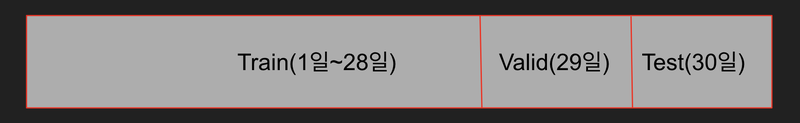
- 이렇게 나누자

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [22]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [23]:
# data에 대한 정보
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5129144
	 Sessions: 1247094
	 Items: 20275
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58100
	 Sessions: 12372
	 Items: 6245
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71041
	 Sessions: 15319
	 Items: 6588
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



- train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.

In [25]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## GRU4REC - Session Based Recommendations with RNN

1. Session parallel mini batches

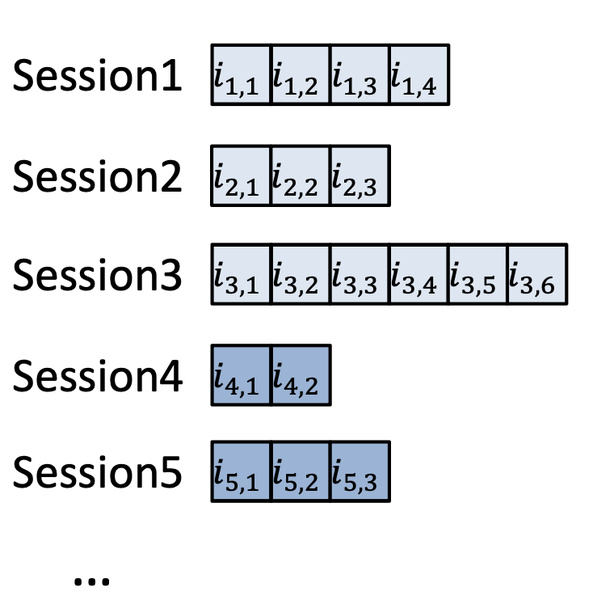

Session의 길이가 매우 짧은 것이 대부분이였는데, 매우 긴 것도 있었다. 하지만 이 긴 세션이 연산이 끝날 때까지 짧은 세션들이 기다려야 한다.
그래서 위 이름처럼 session이 끝날 때까지 기다리지 않고 병렬적으로 계산한다.

## 2. Data pipeline

##### Session Dataset

In [29]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()                 # 각 세션이 시작된 인덱스를 담고 있다.
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # 각 세션을 인덱싱한 np.array

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [30]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


##### Session Dataloader

session dataset 객체를 받아서 session parallel mini batch를 만드는 클래스

In [32]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [36]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [37]:
iter_ex = iter(tr_data_loader)

In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [20 11 22 27]
Label Item Idx are :       [21 12 23 28]
Previous Masked Input Idx are [0 2 3]


## 3. Modeling

##### Evaluation Metric

In [43]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

##### Model Architecture

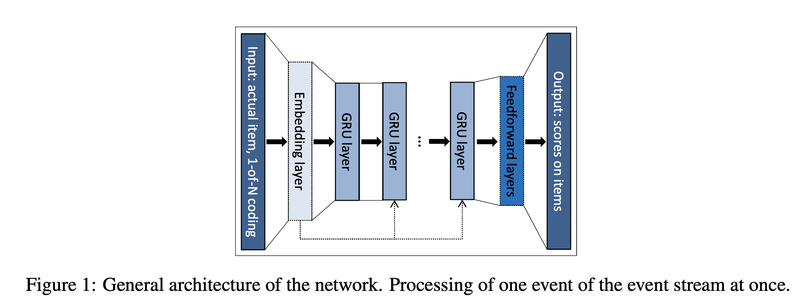

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [46]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [47]:
# model에 사용할 hyper parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [48]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20275)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3049050   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20275)             1034025   
Total params: 4,083,075
Trainable params: 4,083,075
Non-trainable params: 0
_________________________________________________________________


##### Model Training

In [50]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [51]:
train_model(model, args)

Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.408060
	 - MRR@20    epoch 1: 0.143832



Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.594669
	 - MRR@20    epoch 2: 0.241189



Evaluation:  77%|███████▋  | 17/22 [04:11<01:13, 14.77s/it]

	 - Recall@20 epoch 3: 0.664666
	 - MRR@20    epoch 3: 0.287799



##### Test

In [52]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [05:31<01:15, 15.06s/it]

	 - Recall@20: 0.661998
	 - MRR@20: 0.279022

